In [17]:
# Imports
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt 


In [18]:
# Read data and construct dataframe

df = pd.read_csv('datasets/tested_molecules.csv')

df.head()

,SMILES,PKM2_inhibition,ERK2_inhibition
0,C=C(C)c1nc(N)nc(N)n1,0,0
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0


In [19]:
# Load the dataset
df = pd.read_csv('datasets/tested_molecules.csv')  # Replace with your file path

# Function to compute descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        descriptors = {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
            'fr_benzene':Descriptors.fr_benzene(mol),
            'fr_phenol':Descriptors.fr_phenol(mol),
            'fr_NH1':Descriptors.fr_NH1(mol),
            'rotatable_bonds' : Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)
        }
        return descriptors
    else:
        return {key: None for key in descriptor_names}

# Compute descriptors for all molecules
descriptor_names = [
    'MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',  'fr_benzene',
      'fr_phenol', 'rotatable_bonds', 'fr_NH1'
]
df['Descriptors'] = df['SMILES'].apply(compute_descriptors)
descriptors_df = pd.json_normalize(df['Descriptors'])
df = pd.concat([df, descriptors_df], axis=1).drop(columns=['Descriptors'])
df.head()

,SMILES,PKM2_inhibition,ERK2_inhibition,MolWt,LogP,TPSA,NumHDonors,NumHAcceptors,fr_benzene,fr_phenol,fr_NH1,rotatable_bonds
0,C=C(C)c1nc(N)nc(N)n1,0,0,151.173,0.06910,90.71,2,5,0,0,0,1
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,250.681,3.23272,39.44,0,3,1,0,0,3
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0,210.277,0.76110,58.20,2,2,0,0,2,8
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,232.239,0.55792,58.17,0,4,1,0,0,3
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,226.663,1.03540,44.00,0,4,0,0,0,4


In [20]:
# Set the columns which we use for predicting data, so it is easy to change if ever necessary.
x_column = 'SMILES'
y_columns = ['PKM2_inhibition', 'ERK2_inhibition' ]

In [21]:
# Convert SMILES to fingerprints, so we have usable data training

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return list(fp)
    else:
        return [0] * 1024
    
df['Fingerprint'] = df['SMILES'].apply(smiles_to_fingerprint)
x_column = ['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',  'fr_benzene',
      'fr_phenol', 'rotatable_bonds', 'fr_NH1']

df.head()

,SMILES,PKM2_inhibition,ERK2_inhibition,MolWt,LogP,TPSA,NumHDonors,NumHAcceptors,fr_benzene,fr_phenol,fr_NH1,rotatable_bonds,Fingerprint
0,C=C(C)c1nc(N)nc(N)n1,0,0,151.173,0.06910,90.71,2,5,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,250.681,3.23272,39.44,0,3,1,0,0,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0,210.277,0.76110,58.20,2,2,0,0,2,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,232.239,0.55792,58.17,0,4,1,0,0,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,226.663,1.03540,44.00,0,4,0,0,0,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


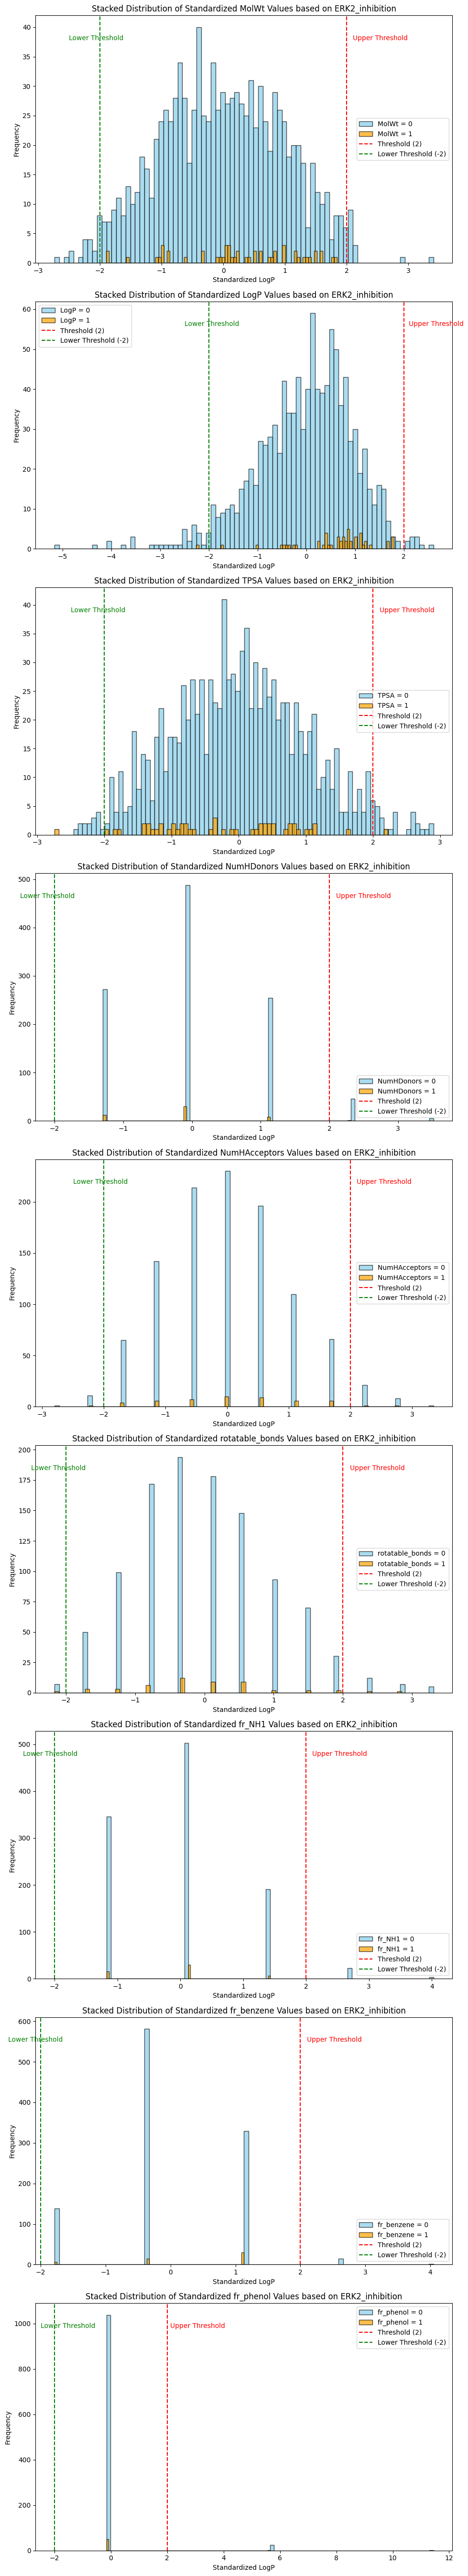

In [22]:
column_names = x_column
z_scores = df[x_column].apply(zscore)
column_names = ['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'rotatable_bonds', 'fr_NH1',  'fr_benzene',
      'fr_phenol']
inhibition_enzyme = 'ERK2_inhibition'


threshold = 2
lower_threshold = -2

# Create subplots for each variable
fig, axs = plt.subplots(len(column_names), 1, figsize=(10, len(column_names)*6))

# Iterate over each variable name
for i, column_name in enumerate(column_names):
    # Compute z-scores for the specified column
    #z_scores = df[column_name].apply(zscore)
    
    # Extract the column values for PKM2_inhibition
    PKM2_inhibition = df[inhibition_enzyme]
    
    # Identify outliers based on z-scores exceeding the thresholds
    outliers = (z_scores.abs() > threshold).any(axis=1)
    
    # Extract z-scores for the column of interest
    z_scores_column = z_scores[column_name]
    
    # Define colors for the bars based on the ratio
    colors = PKM2_inhibition.map({0: 'skyblue', 1: 'orange'})
    
    # Plotting the histogram as a stacked bar histogram
    axs[i].hist(z_scores_column[PKM2_inhibition == 0], bins=80, color='skyblue', edgecolor='black', alpha=0.7, label=f'{column_name} = 0', stacked=True)
    axs[i].hist(z_scores_column[PKM2_inhibition == 1], bins=80, color='orange', edgecolor='black', alpha=0.7, label=f'{column_name} = 1', stacked=True)
    
    # Enhancing plot aesthetics and providing descriptive labels
    axs[i].set_title(f'Stacked Distribution of Standardized {column_name} Values based on {inhibition_enzyme}')
    axs[i].set_xlabel('Standardized LogP')
    axs[i].set_ylabel('Frequency')
    
    # Add vertical lines at the thresholds for visual reference
    axs[i].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
    axs[i].axvline(x=lower_threshold, color='green', linestyle='--', label=f'Lower Threshold ({lower_threshold})')
    
    # Indicate the presence of the thresholds
    axs[i].text(threshold + 0.1, axs[i].get_ylim()[1] * 0.9, 'Upper Threshold', color='red')
    axs[i].text(lower_threshold - 0.5, axs[i].get_ylim()[1] * 0.9, 'Lower Threshold', color='green')
    
    # Add a legend
    axs[i].legend()

plt.tight_layout()
plt.show()

In [23]:
# change outliers to NaN
df1 = df[x_column]

mask = (z_scores.abs() > 2)
mask.head()

df1[mask] = pd.NA

df1.head()


C:\Users\20223037\AppData\Local\Temp\ipykernel_21512\1844016290.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[mask] = pd.NA
C:\Users\20223037\AppData\Local\Temp\ipykernel_21512\1844016290.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[mask] = pd.NA


,MolWt,LogP,TPSA,NumHDonors,NumHAcceptors,fr_benzene,fr_phenol,rotatable_bonds,fr_NH1
0,NaN,0.06910,90.71,2.0,5.0,0.0,0.0,1.0,0.0
1,250.681,3.23272,39.44,0.0,3.0,1.0,0.0,3.0,0.0
2,210.277,0.76110,58.20,2.0,2.0,0.0,0.0,8.0,2.0
3,232.239,0.55792,58.17,0.0,4.0,1.0,0.0,3.0,0.0
4,226.663,1.03540,44.00,0.0,4.0,0.0,0.0,4.0,0.0


In [24]:
z_scores.head()

,MolWt,LogP,TPSA,NumHDonors,NumHAcceptors,fr_benzene,fr_phenol,rotatable_bonds,fr_NH1
0,-2.735972,-1.811345,0.761277,1.108443,-0.007504,-1.786669,-0.15587,-1.708990,-1.169279
1,-1.351495,0.651960,-1.490608,-1.295877,-1.124038,-0.328057,-0.15587,-0.797093,-1.169279
2,-1.913645,-1.272530,-0.666630,1.108443,-1.682305,-1.786669,-0.15587,1.482650,1.427568
3,-1.608083,-1.430733,-0.667948,-1.295877,-0.565771,-0.328057,-0.15587,-0.797093,-1.169279
4,-1.685663,-1.058950,-1.290323,-1.295877,-0.565771,-1.786669,-0.15587,-0.341144,-1.169279


In [25]:
fingerprint_data = df['SMILES'].apply(smiles_to_fingerprint)

finger_print = pd.DataFrame(fingerprint_data)

finger_print.head()
df2 = pd.DataFrame(finger_print['SMILES'].to_list(), columns=[f'Fingerprint_{i}' for i in range(len(finger_print['SMILES'][0]))])

#print(df2.head())


merged_df = pd.concat([df2, df1], axis=1)
merged_df.head()

,Fingerprint_0,Fingerprint_1,Fingerprint_2,Fingerprint_3,Fingerprint_4,Fingerprint_5,Fingerprint_6,Fingerprint_7,Fingerprint_8,Fingerprint_9,...,Fingerprint_1023,MolWt,LogP,TPSA,NumHDonors,NumHAcceptors,fr_benzene,fr_phenol,rotatable_bonds,fr_NH1
0,0,0,0,0,0,0,0,0,0,0,...,0,NaN,0.06910,90.71,2.0,5.0,0.0,0.0,1.0,0.0
1,0,0,0,1,0,0,0,0,0,0,...,0,250.681,3.23272,39.44,0.0,3.0,1.0,0.0,3.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,210.277,0.76110,58.20,2.0,2.0,0.0,0.0,8.0,2.0
3,0,0,0,0,0,0,0,0,0,0,...,0,232.239,0.55792,58.17,0.0,4.0,1.0,0.0,3.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,226.663,1.03540,44.00,0.0,4.0,0.0,0.0,4.0,0.0


In [26]:
# Create test and train sets
x_column = merged_df.columns




X = merged_df[x_column]
y = df[y_columns].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.head())


     Fingerprint_0  Fingerprint_1  Fingerprint_2  Fingerprint_3  \
886              0              0              0              0   
505              0              0              0              0   
761              0              0              0              0   
956              0              0              0              0   
685              0              0              0              0   

     Fingerprint_4  Fingerprint_5  Fingerprint_6  Fingerprint_7  \
886              0              0              0              0   
505              0              0              0              0   
761              0              0              0              0   
956              1              0              0              0   
685              0              0              0              0   

     Fingerprint_8  Fingerprint_9  ...  Fingerprint_1023    MolWt     LogP  \
886              0              0  ...                 0  343.390  3.51830   
505              0              0  ...

In [27]:
# Prediction model

# Define the pipeline
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100)))
])

# Train model
model.fit(X_train, y_train)

# Make prediction using trained model
predictions = model.predict(X_test)
rounded_predictions = (predictions >= 0.3).astype(int)

print(rounded_predictions)

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]

In [28]:
# Calculate prediction scores

# Calculate metrics for each property
accuracy1 = accuracy_score(y_test.iloc[:, 0], rounded_predictions[:, 0])
precision1 = precision_score(y_test.iloc[:, 0], rounded_predictions[:, 0], zero_division=1)
recall1 = recall_score(y_test.iloc[:, 0], rounded_predictions[:, 0], zero_division=1)
f1_1 = f1_score(y_test.iloc[:, 0], rounded_predictions[:, 0], zero_division=1)

accuracy2 = accuracy_score(y_test.iloc[:, 1], rounded_predictions[:, 1])
precision2 = precision_score(y_test.iloc[:, 1], rounded_predictions[:, 1], zero_division=1)
recall2 = recall_score(y_test.iloc[:, 1], rounded_predictions[:, 1], zero_division=1)
f1_2 = f1_score(y_test.iloc[:, 1], rounded_predictions[:, 1], zero_division=1)

# Print the results
print("PKM2 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(accuracy1, precision1, recall1, f1_1))
print("ERK2 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(accuracy2, precision2, recall2, f1_2))

PKM2 - Accuracy: 0.9866, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
ERK2 - Accuracy: 0.9375, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
